In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import fAux
import matplotlib.pyplot as plt
import seaborn as sns
import sys

np.random.seed() #to fix the results
rs = 2
 
#file_path = 'outputfile.txt'
#sys.stdout = open(file_path, "w")


#df = pd.read_csv('EURUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('GBPUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('NZDUSD_H3_200001030000_202107201800.csv', sep='\t')
df = pd.read_csv('USDCAD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('USDCHF_H3_200001030000_202107201800.csv', sep='\t')

df['<DATETIME>'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df = df.set_index('<DATETIME>')
df.drop(['<TIME>'], axis=1, inplace=True)
df.drop(['<DATE>'], axis=1, inplace=True)

#save the open for white reality check
openp = df['<OPEN>'].copy() #for the case we want to enter trades at the open



##build window momentum features
for n in list(range(1,30)):
    name = 'ret' + str(n)
    df[name] = df["<OPEN>"].pct_change(periods=n)#for trading with open
    
    

#build date time features
df["hour"] = df.index.hour.values
df["day"] = df.index.dayofweek.values


#build target assuming we know today's open
df['retFut1'] = df['<OPEN>'].pct_change(1).shift(-1).fillna(0) #if you enter the trade immediately after the open

#df = np.log(df+1)

#Since we are trading right after the open, 
#we only know yesterday's  high low close volume spread etc.
df['<HIGH>'] = df['<HIGH>'].shift(1)
df['<LOW>'] = df['<LOW>'].shift(1)
df['<CLOSE>'] = df['<CLOSE>'].shift(1)
df['<VOL>'] = df['<VOL>'].shift(1)
df['<SPREAD>'] = df['<SPREAD>'].shift(1)

#select the features (by dropping)
cols_to_drop = ["<OPEN>","<HIGH>","<LOW>","<CLOSE>","<TICKVOL>","<VOL>","<SPREAD>"]  #optional
df.drop(cols_to_drop, axis=1, inplace=True)

#distribute the df data into X inputs and y target
X = df.drop(['retFut1'], axis=1)
y = df[['retFut1']]

#select the samples
x_train = X.iloc[0:10000]
x_test = X.iloc[10000:12000]

y_train = y.iloc[0:10000]
y_test = y.iloc[10000:12000]

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit
import detrendPrice 
import WhiteRealityCheckFor1 
from sklearn.preprocessing import FunctionTransformer
# import talib as ta
import ta 
from ta.trend import EMAIndicator 

def information_coefficient(y_true, y_pred):
    rho, pval = spearmanr(y_true,y_pred) #spearman's rank correlation
    print (rho)
    return rho

def sharpe(y_true, y_pred):
    positions = np.where(y_pred> 0,1,-1 )
    dailyRet = pd.Series(positions).shift(1).fillna(0).values * y_true
    dailyRet = np.nan_to_num(dailyRet)
    ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
    return ratio


In [41]:
"""
INSTRUCTIONS
We have already programmed the Pandas and Ta-lib versions of exponential smoothing for you.
Note that inside the pandas_ewm_smoother function, 
you call the corresponding Pandas function,
as per ExponentialSmoothing.pptx with adjust=True.
Similarly inside the talib_ewm_smoother function,
you call the corresponding Ta-lib function.
We will use pandas_ewm_smoother and talib_ewm_smoother inside the FunctionTransformer object.

"""

#PANDAS exponential smoothing:
def pandas_ewm_smoother(x_train, span=None):
    x_train = pd.DataFrame(x_train)
    x_train_smooth = x_train.ewm(span=span, adjust=True).mean()
    return  x_train_smooth.values

#Ta-lib exponential smoothing:
def talib_ewm_smoother(x_train, span=None):  #assumes x_train is an array
    w = np.arange(x_train.shape[0])
    for i in range(0,x_train.shape[1]):
        # a = ta.EMA(x_train[:,i], timeperiod=span) #x_train is an array
        a = EMAIndicator(pd.Series(x_train[:,i]), window=span).ema_indicator().values
        w = np.c_[w,a]
    return w[:,1:]


#myscorer = None #uses the default r2 score, not recommended
#myscorer = "neg_mean_absolute_error"
myscorer = make_scorer(information_coefficient, greater_is_better=True)
#myscorer = make_scorer(sharpe, greater_is_better=True)


In [42]:
"""
INSTRUCTIONS
For proper functioning of exponetial smoothing,
make sure that TimeSeriesSplit is being activated during RandomizedSearchCV and GridSearchCV
to preserve the chronological order of the input series during the construction of the folds.
TimeSeriesSplit is documented here:
https://archive.is/8FZtM
Change the value of split from split=5 to the split created by TimeSeriesSplit with
n_splits set to 5 and max_train_size set to 2000.

"""

#when using smoother, use TimesSeriesSplit
split = 5 
#split = TimeSeriesSplit(n_splits=5, max_train_size=2000) #fixed size window
#split = TimeSeriesSplit(n_splits=5)

In [43]:
"""
INSTRUCTIONS
To use the exponential smoothing functions you need to use the FunctionTransformer object.
The instructions for the FunctionTransformer object are here:
https://archive.is/hsurj

Instantiate a FunctionTransformer object.
Assign the ewm_smoother function or the pandas_smoother_function to the FunctionTransformer object's func parameter.
Save the resulting object in "smoother".
Do this twice, once for pandas_ewm_smoother and again for talib_ewm_smoother.
Each time, assign the resulting object to smoother.
What the FunctionTranformer object is doing is wrapping around the original function 
and provide it with a fit_transform method.

"""
# pandas smoother
smoother = FunctionTransformer(pandas_ewm_smoother, kw_args={'span': 20}, validate=False)
# talib smoother
smoother = FunctionTransformer(talib_ewm_smoother, kw_args={'span': 20}, validate=False)    


In [44]:

numeric_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()),
    ('smoother', smoother),
    ('imputer2', SimpleImputer(strategy='constant', fill_value=0))])
    
categorical_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
print(x_train.dtypes)
numeric_features_ix = x_train.select_dtypes(include=['float64']).columns
categorical_features_ix = x_train.select_dtypes(include=['int64']).columns

#Note: transformer 3-element tuples can be: ['name', function or pipeline, column_number_list or column_index]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_sub_pipeline, numeric_features_ix),
        ('cat', categorical_sub_pipeline, categorical_features_ix)], remainder='passthrough')

ridge = Ridge(max_iter=1000) 

pipe = Pipeline(steps=[('preprocessor', preprocessor),('ridge', ridge)])


a_rs = np.logspace(-7, 0, num=20, endpoint = True)


ret1     float64
ret2     float64
ret3     float64
ret4     float64
ret5     float64
ret6     float64
ret7     float64
ret8     float64
ret9     float64
ret10    float64
ret11    float64
ret12    float64
ret13    float64
ret14    float64
ret15    float64
ret16    float64
ret17    float64
ret18    float64
ret19    float64
ret20    float64
ret21    float64
ret22    float64
ret23    float64
ret24    float64
ret25    float64
ret26    float64
ret27    float64
ret28    float64
ret29    float64
hour       int32
day        int32
dtype: object


In [45]:
"""
INSTRUCTIONS
Note that pandas_ewm_smoother and talib_ewm_smoother have an argument called span that needs to be optimized.
Put possible span values are in spans_rs, for guidance see: https://archive.is/RPs90
Note that you must map each value of span in a separate mapping.
"""

spans_rs = [{'span':s} for s in range(1, 30)]

In [46]:
"""
The tricky part is to construct the parameter grid correctly.
Start by proposing a key like 'preprocessor__kw_args' (it is the wrong key but close enough)
You will get an error.
Following the instructions of the error message:
Print out the list of possible keys by printing out: grid_search.get_params().keys()
Find the correct key and substitute it instead of 'preprocessor__kw_args'
"""

#helpful for setting up param_grid: grid_search.get_params().keys()
param_grid =  [{'preprocessor__num__smoother__kw_args':  spans_rs, 'ridge__alpha': a_rs}]
grid_search = RandomizedSearchCV(pipe, param_grid, cv=split, scoring=myscorer, return_train_score=True, random_state=rs)
#grid_search = GridSearchCV(pipe, param_grid, cv=split, scoring=myscorer, return_train_score=True)



#grid_search.fit(x_train.values, y_train.values.ravel())
grid_search.fit(x_train, y_train.values.ravel())

best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_


print("Best parameters : {}".format(best_parameters))
#print('Best estimator {}'.format(best_model))
print("Best cross-validation score : {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)

#print(results.T)
results.to_csv("results_ridgereg.csv")


0.0513273898604801
0.08831641546262277
0.03986466093922275
0.09158357376685253
0.03979009311109207
0.0954909196740224
0.0728359096972727
0.08180359721307948
0.03682631496250439
0.0932496359092805
0.053756285228146454
0.08917431414799643
0.04145551151910884
0.09288669915700012
0.04123141668528821
0.09655670708742849
0.06347591351397716
0.08508655260700737
0.03741169543690859
0.09374709138542324
0.05589860877089011
0.08951506445482307
0.044069830380826576
0.09268912379302838
0.043582867041021156
0.09680827897330578
0.06482241260409698
0.08656960992561426
0.04245149461139192
0.09446193949776004
0.05288290497528608
0.08932970446647671
0.040581258840041996
0.0926494532593499
0.04159556399904729
0.09638819213950067
0.06366199949577966
0.08478310159863299
0.037008980436734513
0.09345077221905544
0.05422850797777881
0.08953497376122803
0.04372145638679487
0.09271661483867462
0.042540963698433874
0.09657956829600657
0.065357300300613
0.08568891625972282
0.038353585288577165
0.09380182670100852


In [16]:
grid_search.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__preprocessor', 'estimator__ridge', 'estimator__preprocessor__force_int_remainder_cols', 'estimator__preprocessor__n_jobs', 'estimator__preprocessor__remainder', 'estimator__preprocessor__sparse_threshold', 'estimator__preprocessor__transformer_weights', 'estimator__preprocessor__transformers', 'estimator__preprocessor__verbose', 'estimator__preprocessor__verbose_feature_names_out', 'estimator__preprocessor__num', 'estimator__preprocessor__cat', 'estimator__preprocessor__num__memory', 'estimator__preprocessor__num__steps', 'estimator__preprocessor__num__verbose', 'estimator__preprocessor__num__imputer', 'estimator__preprocessor__num__scaler', 'estimator__preprocessor__num__smoother', 'estimator__preprocessor__num__imputer2', 'estimator__preprocessor__num__imputer__add_indicator', 'estimator__preprocessor__num__imputer__copy', 'estimator__preprocessor__num__imputer__fill_value', 'es

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In-sample: CAGR=0.0265751 Sharpe ratio=1.04235 maxDD=-0.0535247 maxDDD=915 Calmar ratio=0.496502

Out-of-sample: CAGR=0.0232932 Sharpe ratio=0.725725 maxDD=-0.0540703 maxDDD=211 Calmar ratio=0.430795  Rho=0.0776447 PVal=0.000509988

Ljung-Box test p-value 0.0015946201790087117
average return -0.000486
[-0.00306767  0.00298088]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.6162000000000001


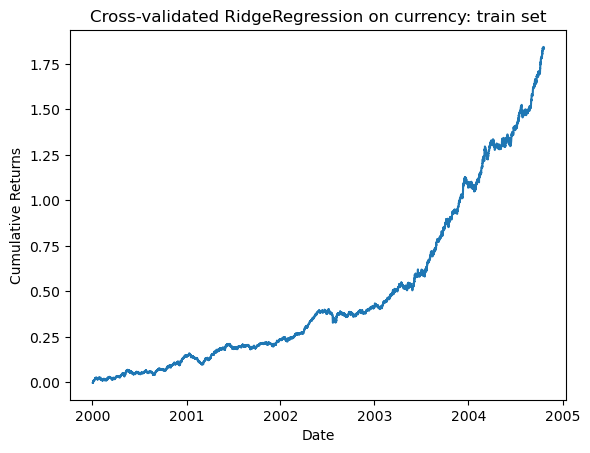

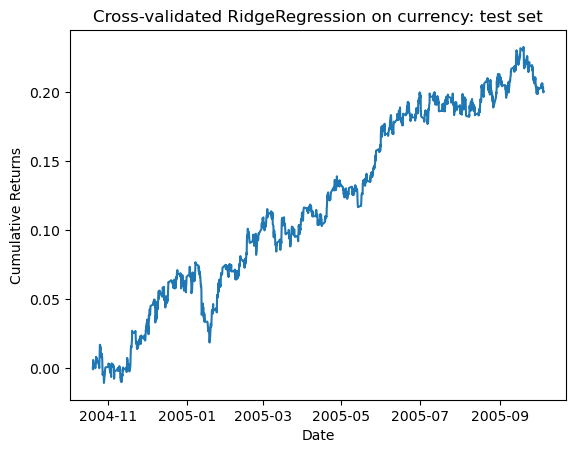

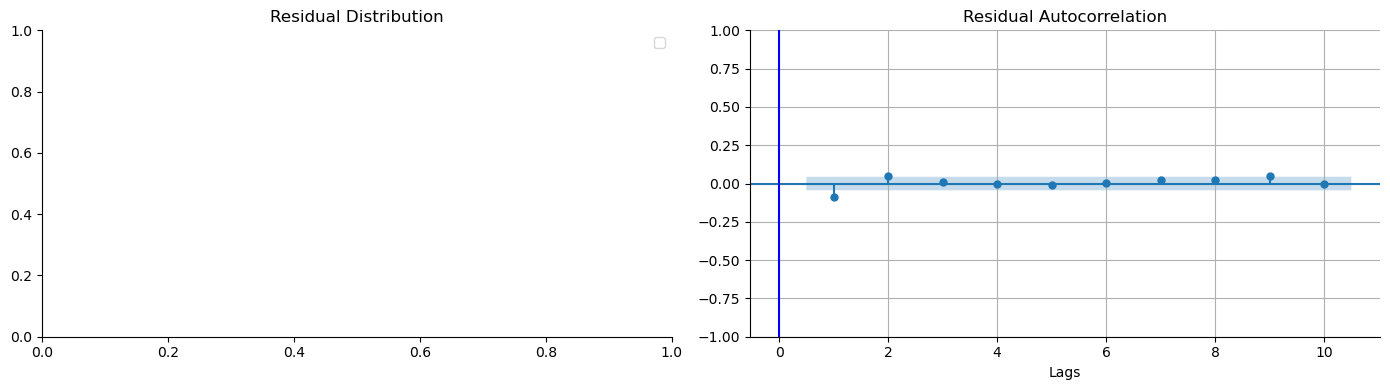

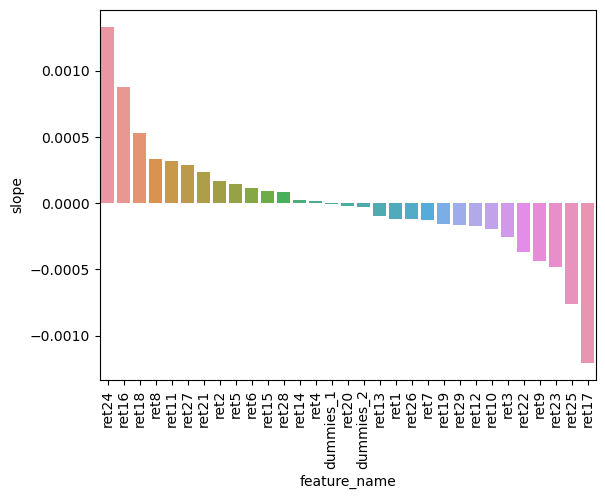

In [47]:
# Train set
# Make "predictions" on training set (in-sample)
#positions = np.where(best_model.predict(x_train)> 0,1,-1 )
positions = np.where(grid_search.predict(x_train)> 0,1,-1 ) #POSITIONS


dailyRet = pd.Series(positions).fillna(0).values * y_train.retFut1 #for trading right after the open

dailyRet = dailyRet.fillna(0)

cumret = np.cumprod(dailyRet + 1) - 1

plt.figure(1)
plt.plot(cumret.index, cumret)
plt.title('Cross-validated RidgeRegression on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TrainCumulative"))


cagr = (1 + cumret[-1]) ** (252 / len(cumret)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

# Test set
# Make "predictions" on test set (out-of-sample)
#positions2 = np.where(best_model.predict(x_test)> 0,1,-1 ) 
positions2 = np.where(grid_search.predict(x_test)> 0,1,-1 ) #POSITIONS


dailyRet2 = pd.Series(positions2).fillna(0).values * y_test.retFut1 #for trading right after the open
dailyRet2 = dailyRet2.fillna(0)

cumret2 = np.cumprod(dailyRet2 + 1) - 1

plt.figure(2)
plt.plot(cumret2.index, cumret2)
plt.title('Cross-validated RidgeRegression on currency: test set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TestCumulative"))

rho, pval = spearmanr(y_test,grid_search.predict(x_test)) #spearman's rank correlation: very small but significant

cagr = (1 + cumret2[-1]) ** (252 / len(cumret2)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret2)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  Rho={:0.6} PVal={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))


#plot the residuals
true_y = y_test.values.ravel()
pred_y = grid_search.predict(x_test)
residuals = np.subtract(true_y, pred_y)

from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
# sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
sns.histplot
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();
#plt.show()
plt.savefig(r'Results\%s.png' %("Residuals"))


#Residual autocorrelation
#If the p-value of the test is greater than the required significance (>0.05), residuals are independent
import statsmodels.api as sm
lb = sm.stats.acorr_ljungbox(residuals, lags=[10], boxpierce=False)
print("Ljung-Box test p-value", lb.iloc[0,1])

#Detrending Prices and Returns and white reality check
detrended_open = detrendPrice.detrendPrice(openp[10000:12000])
detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)
detrended_syst_rets = detrended_retFut1 * pd.Series(positions2).fillna(0)
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)
plt.show()


column_names = numeric_features_ix.values.tolist()
num_dummies = len(best_model[1].coef_.ravel().tolist())-len(column_names)
for i in range(1,num_dummies+1):
    column_names.append('dummies_'+str(i))

#plot the coefficients
importance = pd.DataFrame(zip(best_model[1].coef_.ravel().tolist(), column_names))
importance.columns = ['slope','feature_name']
importance_plot = sns.barplot(x=importance['feature_name'], y=importance['slope'], data=importance,orient='v',dodge=False,order=importance.sort_values('slope',ascending=False).feature_name)
for item in importance_plot.get_xticklabels(): #rotate the x labels by 90 degrees to avoid text overlapping
    item.set_rotation(90)
#plt.show()
plt.savefig(r'Results\%s.png' %("Coefficients"))